# Self Study: Intro to Networks and Centralities

In [2]:
import time
import pandas as pd
import matplotlib.pyplot as plt

try:
    import networkx as nx
except ImportError:
    raise ImportError("NetworkX is not installed: 'pip install networkx'")


## Section 1: Getting Started with NetworkX

NetworkX is a small but expressive library for building, manipulating, and analysing graphs. We will use it throughout the self-study to experiment with economic and social networks.

### Network representations
- **Undirected graphs**: relationships are symmetric (e.g., mutual alliances, co-authorship).
- **Directed graphs (DiGraph)**: edges have a direction (e.g., exports from country *i* to country *j*).
- **Weighted graphs**: edge attributes carry magnitude or cost (e.g., trade volume, shipping time).
- **Multigraphs / bipartite graphs**: allow multiple edges between nodes or encode two node sets (e.g., countries and products). NetworkX exposes dedicated classes (`MultiGraph`, `MultiDiGraph`, `Graph` with `bipartite` attribute) when these structures are required.

### Key concepts we
- **Degree and weight**: number of neighbours and sum of edge weights, proxies for diversification and exposure.
- **Shortest paths**: sequences of nodes that minimise a distance metric; solved via BFS (unweighted) or Dijkstra-type algorithms (weighted) in NetworkX. We will rely on the built-in helpers `nx.shortest_path` and `nx.shortest_path_length`.
- **Centralities**: node scores capturing reach, brokerage, or influence (degree, betweenness, eigenvector, PageRank).


**TASK**

Create the following graphs. Look at `nx.Graph` and `nx.Digraph` and their methods to add edges and nodes, e.g. `graph.add_edges_from`

1. Create an undirected graph
2. Create a directed graph
3. Create a weighted graph
4. Visualise them using and finally learn how to visualise it with NetworkX (look at the documentation for `nx.nx.draw_networkx`)

Encode the structure for this graph (Note: numbers on edges are weights)

['DEU', 'MEX']

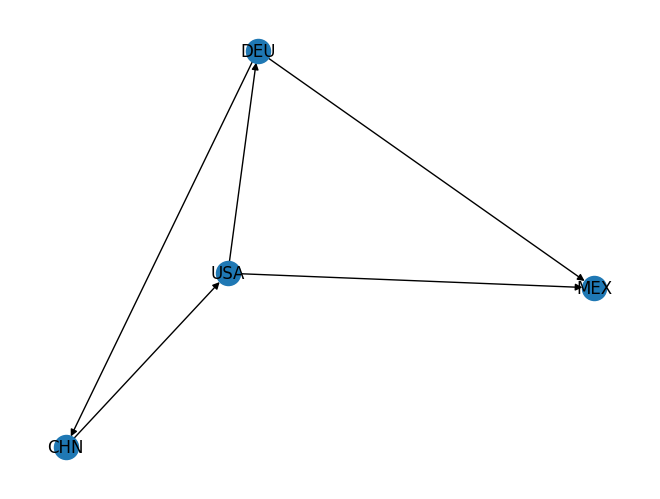

In [24]:
network_1 = nx.DiGraph()
network_1.add_node("DEU")
network_1.add_node("USA")
network_1.add_node("CHN")
network_1.add_node("MEX")

network_1.add_edge("DEU", "MEX", weight=2.5)
network_1.add_edge("DEU", "CHN", weight=1.5)
network_1.add_edge("USA", "DEU", weight=4.0)
network_1.add_edge("USA", "MEX", weight=3.5)
network_1.add_edge("CHN", "USA", weight=5.0)

nx.draw(network_1, with_labels=True)

nx.shortest_path(network_1, source="DEU", target="MEX", weight="weight")


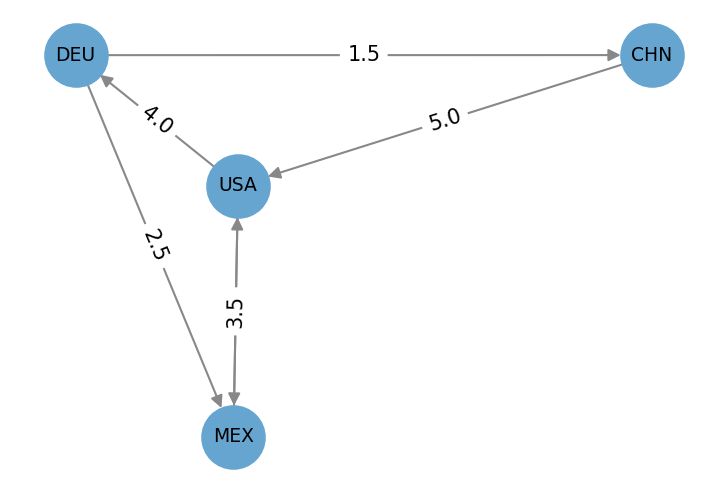

## Section 2: Betweenness Centrality

Betweenness captures how much a node **brokers shortest-path communication** between other pairs.
Nodes with high betweenness can reroute flows, absorb shocks, or gatekeep information.

For a graph ($G=(V,E)$), the betweenness of node ($v$) is

$$
C_B(v) = \sum_{s\ne v\ne t} \frac{\sigma_{st}(v)}{\sigma_{st}},
$$
where ($\sigma_{st}$) counts all shortest paths between ($s$) and ($t$), and ($\sigma_{st}(v)$) counts how many of those paths pass through ($v$).
The term
$$
g_{st}(v) = \frac{\sigma_{st}(v)}{\sigma_{st}}
$$
measures how often ($v$) intermediates communication from ($s$) to ($t$).
To make results comparable across networks we use the normalized version
$$
C_B^{\text{norm}}(v) = \frac{1}{(n-1)(n-2)} \sum_{s\ne v\ne t} g_{st}(v)
$$
(for undirected graphs the denominator is halved).




**Weighted graphs**

If your graph has an edge attribute like `'weight'`, **NetworkX interprets it as a distance or cost** — something to be *minimized* when finding shortest paths.
So, if your weights represent distances, you can use them directly.
If instead they measure *strength* (larger = closer, like trade between countries), you would need to convert them to distances first (for instance, ($\text{distance} = 1 / \text{strength}$)).



**TASK:** Compute betweenness centrality

1. Use `nx.all_shortest_paths` (with optional `weight`) to list all shortest routes between every ordered pair $(s,t)$.
2. For each path, add a contribution ($g_{st}(v) = 1 / \sigma_{st}$) to each internal node $v$.
3. Normalize the resulting scores so that values lie in ($[0,1]$).


In [56]:
def betweenness_via_shortest_paths(graph, normalized=True, weights=True) -> dict:
    """
    Compute betweenness centrality by enumerating all shortest paths.

    Parameters
    ----------
    graph : nx.Graph or nx.DiGraph
    normalized : bool
        If True, scales results to [0,1].
    weights : bool
        - True: use weights attribute
            - False: ignora eventuali pesi e usa cammini non pesati (0/1 in base alla presenza dell’arco).

    """
    from networkx.exception import NetworkXNoPath

    nodes = list(graph.nodes())
    n = len(nodes)
    betweenness = dict.fromkeys(nodes, 0.0)

    if n < 3:
        return "Graph too small for betweenness centrality"

    # Determina se usare pesi: se weights=False forza non pesato
    use_weight = False
    if weights:
        # usa pesi solo se l'attributo 'weight' è presente su almeno un arco
        use_weight = any("weight" in data for _, _, data in graph.edges(data=True))

    for s in nodes:
        for t in nodes:
            if s == t:
                continue
            try:
                if use_weight:
                    paths = list(nx.all_shortest_paths(graph, source=s, target=t, weight="weight"))
                else:
                    # non pesato: ogni arco vale 1
                    paths = list(nx.all_shortest_paths(graph, source=s, target=t))
            except NetworkXNoPath:
                continue

            sigma_st = len(paths)
            if sigma_st == 0:
                continue
            contrib = 1.0 / sigma_st
            for path in paths:
                for v in path[1:-1]:  # solo nodi interni
                    betweenness[v] += contrib

    if normalized:
        if graph.is_directed():
            factor = 1.0 / ((n - 1) * (n - 2))
        else:
            factor = 2.0 / ((n - 1) * (n - 2))
        for v in betweenness:
            betweenness[v] *= factor

    return betweenness



Graph algorithms such as **betweenness centrality** are computationally demanding because they rely on finding shortest paths between all pairs of nodes in a network. For a graph with ($n$) nodes, there are ( $n(n-1)$ ) possible pairs of distinct nodes. Even if we consider only unique pairs in an undirected graph, this still scales on the order of ($n^2$).

Computing a single shortest path can already be costly, especially for large or weighted graphs. For instance, Dijkstra’s algorithm—commonly used for weighted networks—has a computational complexity of ( $O(m + n \log n)$ ), where ( $m$ ) is the number of edges. When this operation must be repeated for every node pair, the total cost grows rapidly, making a naive implementation prohibitively slow for large graphs.

In short, while a simple “by-enumeration” approach to betweenness centrality (as in our example function) is conceptually straightforward and produces correct results, it is far from computationally efficient.

By contrast, **NetworkX** employs more sophisticated algorithms based on **Brandes’ algorithm (2001)** (Prof @ ETH), which dramatically reduces the computational cost. Brandes’ method leverages the structure of shortest-path trees to avoid redundant calculations, lowering the time complexity to ( $O(nm)$ ) for unweighted graphs and ( $O(nm + n^2 \log n)$ ) for weighted graphs.

Below, we compare our simple implementation to the efficient, built-in version in `networkx` to highlight the difference in computational performance. The key takeaway is that while these network measures are conceptually intuitive, making them scalable often requires relying on more advanced algorithms or on “good-enough” approximations that trade some accuracy for substantial gains in speed.


### Runtime scaling on random graphs

To see how the pedagogical implementation degrades, the next cell benchmarks both methods on Erdős–Rényi graphs with \(n\in\{10,20,100\}\), averaging a few runs per size and plotting the median runtime (log scale). Adjust the edge probability or number of runs if execution takes too long.

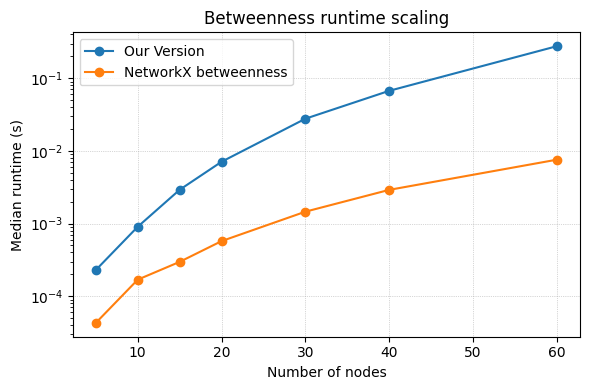

In [55]:
sizes = [5, 10, 15, 20, 30, 40, 60]
edge_prob = 0.2
runs_per_size = 3
records: list[dict[str, float]] = []

for n in sizes:
    for run in range(runs_per_size):
        graph = nx.gnp_random_graph(n, edge_prob, directed=False)

        start = time.perf_counter()
        betweenness_via_shortest_paths(graph)
        custom_sec = time.perf_counter() - start

        start = time.perf_counter()
        nx.betweenness_centrality(graph, normalized=True)
        builtin_sec = time.perf_counter() - start

        records.append({
            "n": graph.number_of_nodes(),
            "run": run,
            "custom_sec": custom_sec,
            "builtin_sec": builtin_sec,
        })

runtime_df = pd.DataFrame(records)
summary = runtime_df.groupby("n")[["custom_sec", "builtin_sec"]].median().reset_index()

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(summary["n"], summary["custom_sec"], marker="o", label="Our Version")
ax.plot(summary["n"], summary["builtin_sec"], marker="o", label="NetworkX betweenness")
ax.set_yscale("log")
# ax.set_xscale("log")
ax.set_xlabel("Number of nodes")
ax.set_ylabel("Median runtime (s)")
ax.set_title("Betweenness runtime scaling")
ax.grid(True, linestyle=":", linewidth=0.5)
ax.legend()
plt.tight_layout()
plt.show()

## Section 3: International Trade Network Case Study

We now turn to a real-world example: the **international trade network**, based on data from **UN Comtrade** (`trade_1988_2021.csv`), which reports bilateral trade values (in thousand USD).

Download the file `trade_1988_2021.csv.zip`, unzip it, and place it in the same directory as this notebook.
(You may need to adjust the `DATA_PATH` variable below.)

---

### **TASK**

1. **Load and filter** export data while preserving the yearly structure.
2. **Create a weighted directed graph (`DiGraph`)** from `trade_df`, where edges represent exports from `reporter → partner`.
3. **Compute betweenness centrality** for each country-year:

   * **Unweighted** (all edges treated equally)
   * **Weighted by inverse trade value**, since trade represents *strength*, not *distance*.

     > *Note:* To use trade values as weights in shortest-path algorithms, convert them to costs:
     > `weight = 1 / trade_value` (see Section 1 comment)
4. **Plot** betweenness centrality over time (1989–2020) for the **top five countries** ranked by their 2020 betweenness scores.


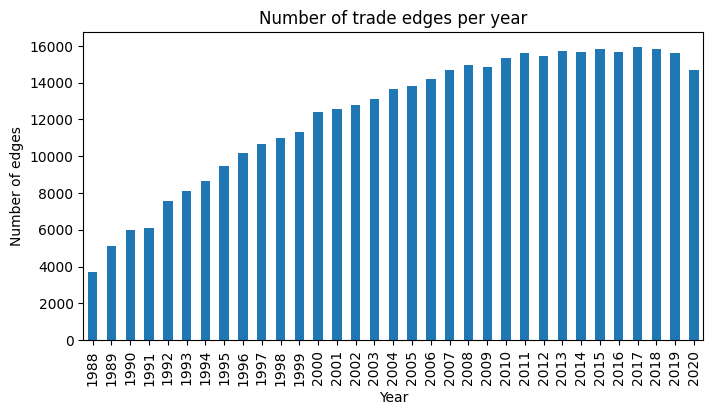

In [41]:
## CODE PROVIDED --- NO NEED TO EDIT; Make sure `DATA_PATH` points to the CSV file

import pandas as pd
from pathlib import Path
import networkx as nx

DATA_PATH = Path("trade_1988_2021.csv").resolve()
FLOW = "Export"
MIN_TRADE_USD = 500_000 # Minimum trade value to include an edge; gets rid of noise

trade_df = pd.read_csv(DATA_PATH)
trade_df = trade_df.query("TradeFlowName == @FLOW").copy()
trade_df["TradeValueUSD"] = trade_df["TradeValue in 1000 USD"].astype(float) * 1000.0
del trade_df["TradeValue in 1000 USD"]
del trade_df["TradeFlowName"]
trade_df = trade_df.loc[trade_df["ReporterISO3"] != trade_df["PartnerISO3"]]
trade_df = trade_df.loc[trade_df["TradeValueUSD"] >= MIN_TRADE_USD]
trade_df = trade_df.loc[trade_df["PartnerISO3"] != "WLD"]
trade_df = trade_df.loc[trade_df["ReporterISO3"] != "WLD"]
trade_df = trade_df.loc[trade_df["Year"] != 2021]

trade_df.sort_values(by=["Year", "ReporterISO3", "PartnerISO3"], inplace=True)

## PLOT NUMBER OF EDGES PER YEAR
trade_df.groupby("Year").size().plot(kind="bar", figsize=(8, 4), title="Number of trade edges per year")
plt.xlabel("Year")
plt.ylabel("Number of edges")
plt.show()

In [47]:
#cumulative trades (useless)

all_time_network = nx.DiGraph()

reporters = trade_df["ReporterISO3"].unique()
partners = trade_df["PartnerISO3"].unique()
all_countries = set(reporters).union(set(partners))
all_countries = pd.Series(list(all_countries)).unique()

for _, row in trade_df.iterrows():
    reporter = row["ReporterISO3"]
    partner = row["PartnerISO3"]
    value = row["TradeValueUSD"]
    weight = 1/value  # using inverse trade value as weight
    if all_time_network.has_edge(reporter, partner):
        all_time_network[reporter][partner]["weight"] += weight
    else:
        all_time_network.add_edge(reporter, partner, weight=weight)



### Answer — Sezione 3 (betweenness su rete commerciale)
- Usiamo pesi come costo: `weight = 1 / TradeValueUSD` (peso più basso = collegamento più "vicino").
- Per scalabilità impieghiamo `networkx.betweenness_centrality` (Brandes), non l’enumerazione didattica.
- Calcoliamo per anno 1989–2020: versione pesata e non pesata.
- Selezioniamo le top‑5 del 2020 (pesata) e tracciamo l’evoluzione temporale.
Nota: la cella precedente che usa `years` e la funzione didattica può essere ignorata se lenta.

In [ ]:
# Anni di analisi (coerenti con il task) e garanzia dei grafi annuali
years = sorted(y for y in trade_df["Year"].unique() if 1989 <= y <= 2020)

yearly_networks = {}
for year in years:
    G = nx.DiGraph()
    yr = trade_df[trade_df["Year"] == year]
    for _, row in yr.iterrows():
            u = row["ReporterISO3"] 
            v = row["PartnerISO3"]
            val = float(row["TradeValueUSD"])
            if u == v:
                continue
            w = 1.0 / val  # costo = inverso del valore di scambio
            if G.has_edge(u, v):
                G[u][v]["weight"] += w
            else:
                G.add_edge(u, v, weight=w)
    
    yearly_networks[year] = G

len(years)
list(yearly_networks.keys())[:3]
list(yearly_networks.keys())[-3:]

(32, [1989, 1990, 1991], [2018, 2019, 2020])

In [ ]:
weighted_betweenness_per_year_nx = {}
unweighted_betweenness_per_year_nx = {}

for year in years:
    weighted_betweenness_per_year_nx[year] = betweenness_via_shortest_paths(yearly_networks[year], normalized=True, weights=True)
    unweighted_betweenness_per_year_nx[year] = betweenness_via_shortest_paths(yearly_networks[year], normalized=True, weights=False)



In [ ]:
#select 5 countries by their betweenness in 2020 (weighted)
top_countries_2020 = sorted(weighted_betweenness_per_year_nx[2020].items(), key=lambda x: x[1], reverse=True)[:5]

#filter betweeness for top countries from the 2020 ranking
betweenness_top_countries_weighted = {country: [] for country, _ in top_countries_2020}
betweenness_top_countries_unweighted = {country: [] for country, _ in top_countries_2020}

#plot yearly betweenness for top countries (weighted only)
for year in years:
    for country, _ in top_countries_2020:
        betweenness_top_countries_weighted[country].append(weighted_betweenness_per_year_nx[year].get(country, 0.0))

#plot matbplotlib
plt.figure(figsize=(10, 6))
for country, _ in top_countries_2020:
    plt.plot(years, betweenness_top_countries_weighted[country], marker='o', label=country) 
plt.title("Yearly Weighted Betweenness Centrality of Top 5 Countries in 2020")
plt.xlabel("Year")
plt.ylabel("Weighted Betweenness Centrality")
plt.legend()
plt.grid(True)
plt.show()
